# Autoencoders

In [4]:
# Import required libs
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense,Dropout, GaussianNoise
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import constraints
from tensorflow.keras.losses import MeanSquaredError
from keras.models import load_model


import warnings
warnings.filterwarnings("ignore")

In [5]:
## import datasets
ratings_df = pd.read_csv("../data/Ratings.csv")
books_df = pd.read_csv("../data/Books.csv")
users_df = pd.read_csv("../data/Users.csv")

In [6]:
# Merge datasets
df = ratings_df.merge(books_df, on='ISBN').merge(users_df, on='User-ID')

# Remove duplicates and unnecessary columns
df.drop_duplicates(subset=['User-ID', 'Book-Title'], keep='last', inplace=True)
df.drop(columns=['ISBN', 'Year-Of-Publication'], inplace=True)

# Filter out users and books with too few ratings
user_counts = df['User-ID'].value_counts()
book_counts = df['Book-Title'].value_counts()
df = df[df['User-ID'].isin(user_counts[user_counts >= 5].index)]
df = df[df['Book-Title'].isin(book_counts[book_counts >= 5].index)]

# Create user-item interaction matrix
interaction_matrix = df.pivot(index='User-ID', columns='Book-Title', values='Book-Rating').fillna(0)

# Encode user and item IDs
user_enc = LabelEncoder()
interaction_matrix.index = user_enc.fit_transform(interaction_matrix.index)

# Normalize ratings
scaler = MinMaxScaler()
interaction_matrix_normalized = scaler.fit_transform(interaction_matrix)


In [17]:
interaction_matrix.to_csv("../BiblioBeacon_app/AE_recommender/interaction_matrix.csv")


KeyboardInterrupt



In [15]:
np.save('../BiblioBeacon_app/AE_recommender/interaction_matrix_normalized.npy', interaction_matrix_normalized)


In [4]:
# v1

# Define the number of input dimensions
num_users, num_books = interaction_matrix_normalized.shape

# Define the autoencoder model
input_layer = Input(shape=(num_books,))

# Encoding layers
encoded = Dense(256, activation='relu')(input_layer)
encoded = Dropout(0.2)(encoded)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dropout(0.1)(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = GaussianNoise(0.1)(encoded)  # Denoising autoencoder
encoded = Dense(32, activation='relu')(encoded)  # Bottleneck layer

# Decoding layers
decoded = Dense(64, activation='relu')(encoded)
decoded = Dropout(0.1)(decoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dropout(0.2)(decoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dense(num_books, activation='sigmoid')(decoded)

# Define the autoencoder model
autoencoder = Model(input_layer, decoded)

# Compile the model
autoencoder.compile(optimizer=Adam(learning_rate =0.001), loss=MeanSquaredError())

In [4]:
# v2

from keras.regularizers import l1_l2

# Define the number of input dimensions
num_users, num_books = interaction_matrix_normalized.shape

# Define the autoencoder model
input_layer = Input(shape=(num_books,))

# Encoding layers
encoded = Dense(512, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(input_layer)
encoded = Dropout(0.3)(encoded)
encoded = Dense(256, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(encoded)
encoded = Dropout(0.2)(encoded)
encoded = Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(encoded)
encoded = Dropout(0.1)(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = GaussianNoise(0.1)(encoded)  # Denoising autoencoder
encoded = Dense(32, activation='relu')(encoded)  # Bottleneck layer

# Decoding layers
decoded = Dense(64, activation='relu')(encoded)
decoded = Dropout(0.1)(decoded)
decoded = Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(decoded)
decoded = Dropout(0.2)(decoded)
decoded = Dense(256, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(decoded)
decoded = Dropout(0.3)(decoded)
decoded = Dense(512, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(decoded)
decoded = Dense(num_books, activation='sigmoid')(decoded)

# Define the autoencoder model
autoencoder = Model(input_layer, decoded)

# Compile the model
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())

In [8]:
from keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the autoencoder model
history = autoencoder.fit(
    interaction_matrix_normalized,
    interaction_matrix_normalized,
    epochs=100,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

In [14]:
from keras.models import load_model

autoencoder2 = load_model('../scripts/AE_model/autoencoder_model.h5')

In [7]:
# # Train the autoencoder
# history2 = autoencoder.fit(
#     interaction_matrix_normalized,
#     interaction_matrix_normalized,
#     epochs=50,
#     batch_size=256,
#     shuffle=True,
#     validation_split=0.2
# )

In [5]:
# Train the autoencoder
history = autoencoder.fit(
    interaction_matrix_normalized,
    interaction_matrix_normalized,
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_split=0.2
)

Epoch 1/50

64/64 [==============================] - 51s 696ms/step - loss: 0.0993 - val_loss: 1.8698e-04
Epoch 2/50
64/64 [==============================] - 34s 531ms/step - loss: 1.8952e-04 - val_loss: 1.8698e-04
Epoch 3/50
64/64 [==============================] - 39s 611ms/step - loss: 1.8952e-04 - val_loss: 1.8698e-04
Epoch 4/50
64/64 [==============================] - 39s 605ms/step - loss: 1.8952e-04 - val_loss: 1.8698e-04
Epoch 5/50
64/64 [==============================] - 33s 523ms/step - loss: 1.8952e-04 - val_loss: 1.8698e-04
Epoch 6/50
64/64 [==============================] - 31s 492ms/step - loss: 1.8952e-04 - val_loss: 1.8698e-04
Epoch 7/50
64/64 [==============================] - 34s 527ms/step - loss: 1.8952e-04 - val_loss: 1.8698e-04
Epoch 8/50
64/64 [==============================] - 32s 494ms/step - loss: 1.8952e-04 - val_loss: 1.8698e-04
Epoch 9/50
64/64 [==============================] - 31s 490ms/step - loss: 1.8952e-04 - val_loss: 1.8698e-04
Epoch 10/50
64/64 [===

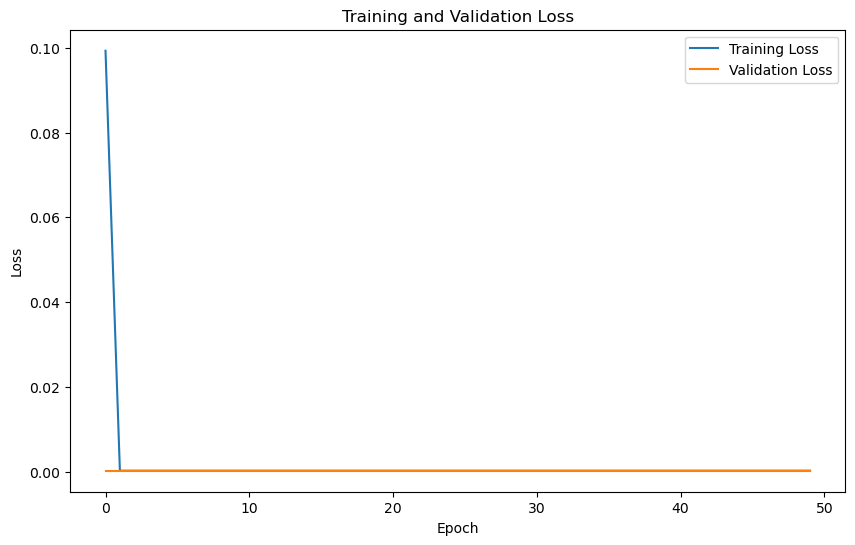

In [6]:
# Get the training and validation loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [7]:
# Calculate the RMSE
final_val_loss = val_loss[-1]
rmse = np.sqrt(final_val_loss)
print(f"Final Validation RMSE: {rmse:.4f}")

Final Validation RMSE: 0.0137


In [29]:
mae = val_loss[-1]
print(f"Final Validation MAE: {mae:.4f}")

Final Validation MAE: 0.0002


In [8]:
import pickle

with open('history_v2.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [10]:
with open('history_v2.pkl', 'rb') as file_pi:
    loaded_history = pickle.load(file_pi)

In [12]:
autoencoder.save('../scripts/AE_model/autoencoder_model_v2.h5')

In [28]:
# Function to make book recommendations
def recommend_books(user_id, num_recommendations=5):
    # Encode the user ID
    encoded_user_id = user_enc.transform([user_id])[0]
    
    # Get the user's ratings
    user_ratings = interaction_matrix_normalized[encoded_user_id].reshape(1, -1)
    
    # Predict ratings for all books
    predicted_ratings = autoencoder.predict(user_ratings)
    
    # Convert predicted ratings to a Pandas Series
    predicted_ratings = pd.Series(predicted_ratings.flatten(), index=interaction_matrix.columns)
    
    # Get books the user has not rated
    user_original_ratings = interaction_matrix.loc[encoded_user_id]
    unrated_books = user_original_ratings[user_original_ratings == 0].index
    
    # Recommend the top n books
    recommendations = predicted_ratings.loc[unrated_books].sort_values(ascending=False).head(num_recommendations)
    
    return recommendations.index.tolist()

# Test the recommendation system
user_id = 2012  # Replace with a valid user ID
recommended_books = recommend_books(user_id, num_recommendations=5)
print(f"Top 5 recommended books for user {user_id}:")
for r in recommended_books:
    print(r)
    print("-"*50)


1/1 [==============================] - 0s 62ms/step
Top 5 recommended books for user 2012:
Spam-Ku : Tranquil Reflections on Luncheon Loaf
--------------------------------------------------
Immortality
--------------------------------------------------
Pale Gray for Guilt (Travis McGee Mysteries (Paperback))
--------------------------------------------------
La Mort Ã?Â  Venise
--------------------------------------------------
Bad Boys in Black Tie
--------------------------------------------------


In [7]:
# Load the entire model
from keras.models import load_model
autoencoder = load_model('../scripts/AE_model/autoencoder_model.h5')

In [9]:
user_id = int(input("enter ur user id: "))
num_recommendations = int(input("how many new books u want to discover ! : "))

encoded_user_id = user_enc.transform([user_id])[0]

user_ratings = interaction_matrix_normalized[encoded_user_id].reshape(1, -1)

predicted_ratings = autoencoder.predict(user_ratings)

predicted_ratings = pd.Series(predicted_ratings.flatten(), index=interaction_matrix.columns)


user_original_ratings = interaction_matrix.loc[encoded_user_id]

unrated_books = user_original_ratings[user_original_ratings == 0].index


recommendations = predicted_ratings.loc[unrated_books].sort_values(ascending=False).head(num_recommendations)


recommended_books = recommendations.index
recommended_books

enter ur user id: 2033
how many new books u want to discover ! : 5
1/1 [==============================] - 0s 89ms/step


Index([' Earth Prayers From around the World: 365 Prayers, Poems, and Invocations for Honoring the Earth',
       'Speak Only Love', 'Spares',
       'Sparhawk'S Angel (Harlequin Historical, No 315)', 'Sparkling Cyanide'],
      dtype='object', name='Book-Title')

In [18]:
for r in recommended_books:
    print(r)

 Earth Prayers From around the World: 365 Prayers, Poems, and Invocations for Honoring the Earth
Speak Only Love
Spares
Sparhawk'S Angel (Harlequin Historical, No 315)
Sparkling Cyanide


In [17]:
# Function to make book recommendations
def recommend_books(user_id, num_recommendations=5):
    # Encode the user ID
    encoded_user_id = user_enc.transform([user_id])[0]
    
    # Get the user's ratings
    user_ratings = interaction_matrix_normalized[encoded_user_id].reshape(1, -1)
    
    # Predict ratings for all books
    predicted_ratings = autoencoder.predict(user_ratings)
    
    # Convert predicted ratings to a Pandas Series
    predicted_ratings = pd.Series(predicted_ratings.flatten(), index=interaction_matrix.columns)
    
    # Get books the user has not rated
    user_original_ratings = interaction_matrix.loc[encoded_user_id]
    unrated_books = user_original_ratings[user_original_ratings == 0].index
    
    # Recommend the top n books
    recommendations = predicted_ratings.loc[unrated_books].sort_values(ascending=False).head(num_recommendations)
    
    return recommendations

# Test the recommendation system
user_id = 2012  # Replace with a valid user ID
recommended_books = recommend_books(user_id, num_recommendations=5)
print(f"Top 5 recommended books for user {user_id}:")
print(recommended_books)


1/1 [==============================] - 0s 362ms/step
Top 5 recommended books for user 2012:
Book-Title
A History of the World in 10 1/2 Chapters (Vintage International)    8.646803e-35
Der gemietete Mann.                                                  6.491739e-35
The Healing Quilt                                                    6.351720e-35
El Baron Rampante                                                    6.205719e-35
China Men (Vintage International (Paperback))                        6.195642e-35
dtype: float32
